In [10]:
from remote_vgk import *

import numpy as np
import matplotlib.pyplot as plt 

In [11]:
def load_password(path):

    with open(path) as f:
        secrets = json.load(f)
        shifted_pwd = secrets['password']
    pwd = ''
    for s in shifted_pwd:
        pwd += chr(ord(s) - 1)

    return pwd

In [12]:
try:
    window = gw.getWindowsWithTitle("millenicut:19")[0]
except IndexError:
    raise Exception("Window not found")

pwd = load_password('secrets.json')
sesh = DPO_Session('lwp26', pwd)

# Create the AirfoilApp
App = AirfoilApp(sesh.teaching_client, window, "2.3_incidence_aerofoil")

# IMPORTANT SET THE SAME PARAMETERS AS ON THE APP
App.alpha = 2.3
App.M = 0.75
App.Re = 10


C:\Users\louis\AppData\Local\Temp\ipykernel_64776\2206068518.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Angle of Attack [deg]')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


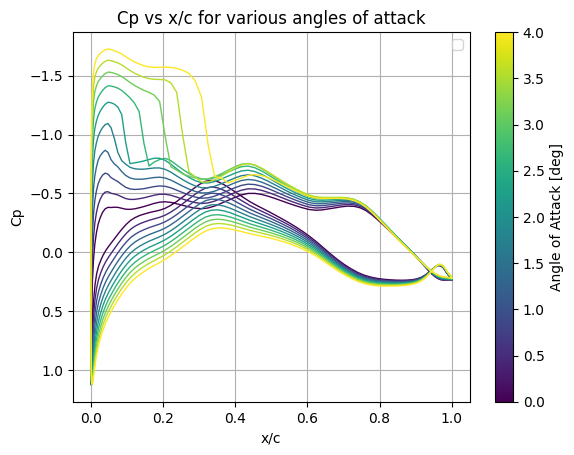

In [13]:
nalph = 10
alphas = np.linspace(0, 4, nalph)
cs = plt.cm.viridis(np.linspace(0, 1, nalph))
M = 0.7

plt.gca().invert_yaxis()
i = 0

for alpha in alphas:
    res = App.run(M, alpha, 10)
    if res is None:
        continue

    plt.plot(res.x, res.cp, color=cs[i], linewidth = 1)

    i += 1

# add colourbar

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=alphas.min(), vmax=alphas.max()))
sm._A = []

plt.colorbar(sm, label='Angle of Attack [deg]')

plt.xlabel('x/c')
plt.ylabel('Cp')

plt.title('Cp vs x/c for various angles of attack')

plt.grid()
plt.legend()


plt.savefig('figures/cp_vs_xc_alphas.png')

C:\Users\louis\AppData\Local\Temp\ipykernel_64776\3989120913.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Mach number')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


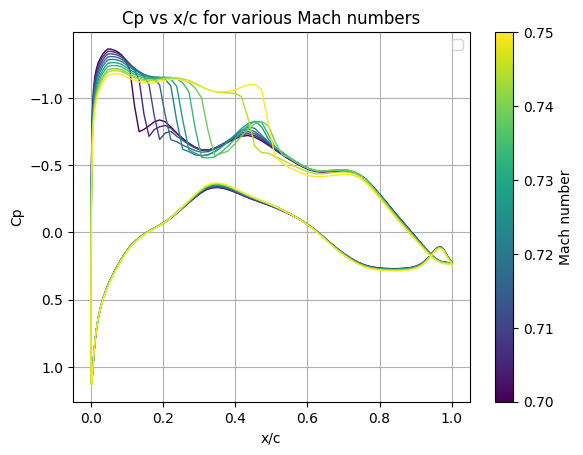

In [14]:
nmach = 10
alpha = 2.5
machs = np.linspace(0.7, 0.75, nmach)
cs = plt.cm.viridis(np.linspace(0, 1, nalph))

plt.gca().invert_yaxis()
i = 0

for m in machs:
    res = App.run(m, alpha, 10)
    if res is None:
        continue

    plt.plot(res.x, res.cp, color=cs[i], linewidth = 1)

    i += 1

# add colourbar

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=machs.min(), vmax=machs.max()))
sm._A = []

plt.colorbar(sm, label='Mach number')

plt.xlabel('x/c')
plt.ylabel('Cp')

plt.title('Cp vs x/c for various Mach numbers')

plt.grid()
plt.legend()


plt.savefig('figures/cp_vs_xc_machs.png')

In [18]:
# 100 runs takes ~ 5 minutes
machs = np.linspace(0.75, 0.8, 10)
alphas = np.linspace(2, 2.6, 10)

for m in machs:
    for a in alphas:
        res = App.run(m, a, 10)


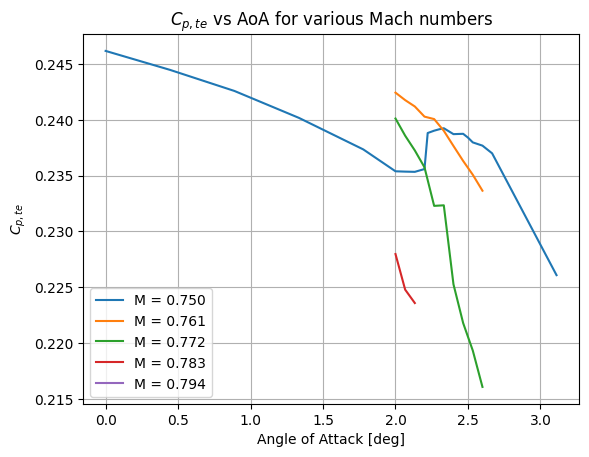

In [22]:

for m in machs[::2]:
    als, cps = App.cpte_alpha(m, 10)

    plt.plot(als, cps, label=f'M = {m:.3f}')

plt.xlabel('Angle of Attack [deg]')
plt.ylabel('$C_{p,te}$')

plt.title('$C_{p,te}$ vs AoA for various Mach numbers')

plt.grid()
plt.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


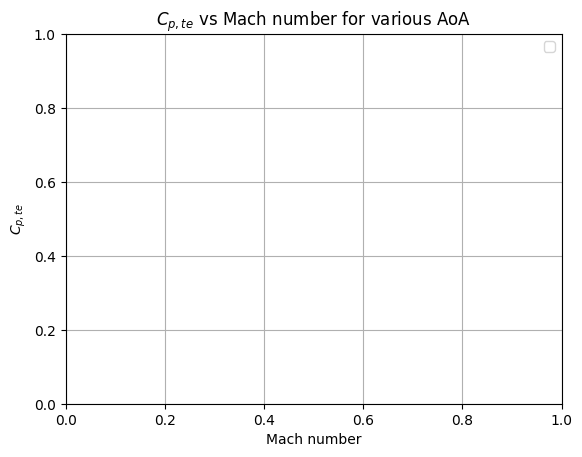

In [21]:
alphas = np.linspace(2, 2.6, 10)
for a in alphas[::2]:
    machs, cps = App.cpte_M(a, 10)

    plt.plot(machs, cps, label=f'Alpha = {a:.3f}')


plt.xlabel('Mach number')
plt.ylabel('$C_{p,te}$')

plt.title('$C_{p,te}$ vs Mach number for various AoA')

plt.grid()
plt.legend()
